In [2]:
%matplotlib widget

from datetime import datetime
import backtrader as bt
import backtrader.feeds as btfeeds
import yfinance as yf
import tulipy as ta
import matplotlib.pyplot as plt
import tiingo
import pandas as pd 
import pyfolio as pf
import math
import numpy as np

X:\Environments\Backtesting\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


# QuantStats

In [34]:
class QuantConnectCSVData(btfeeds.GenericCSVData):
    params = (
        ('nullvalue', float('NaN')),
        ('dtformat', '%Y:%m:%d'),
        ('datetime', 0),
        ('time', 1),
        ('open', 2),
        ('high', 3),
        ('low', 4),
        ('close', 5),
        ('volume', 6),
        ('openinterest', -1),
        ('timeframe', bt.TimeFrame.Minutes), 
        ('compression', 240),
    )

In [4]:
class TiingoCSVData(btfeeds.GenericCSVData):
    params = (
        ('nullvalue', float('NaN')),
        ('dtformat', '%Y-%m-%d'),
        ('datetime', 0),
        ('open', 9),
        ('high', 7),
        ('low', 8),
        ('close', 6),
        ('volume', 10),
        ('openinterest', -1),
    )

In [15]:
spy_data = client.get_dataframe("SPY",
                                    frequency='daily',
                                    startDate=start_date,
                                    endDate=end_date)

spy_data = spy_data.tz_convert(None)
dfdates = pd.DataFrame(index=spy_data.index)

In [18]:
from tiingo import TiingoClient

client = TiingoClient({'api_key' : '7fb8e25ac6335f846ae82d3f3a28ed535f313592'})

datalist = ["SPY", "XLK", "XLB", "XLE", "XLF", "XLI" , "XLP", "XLU", "XLV", "XLY", "XLC"]

start_date = '2010-02-02'
end_date = '2020-10-10'

for i in range(len(datalist)):
  data = client.get_dataframe(datalist[i],
                                        frequency='daily',
                                        startDate=start_date,
                                        endDate=end_date)
  
  data = data.tz_convert(None)
  dfdates.join(data, how='left').fillna(0).to_csv("data/ETFs/{}.csv".format(datalist[i]))


In [41]:
class RSIt(bt.Strategy):

    params = (('oneplot', True),
                ('tp_multiplier', 5),
                ('sl_multiplier', 3),
                ('ATR_Period', 14),
                ('bk_period', 100),
                )

    def __init__(self):
        self.inds = dict()
        for i, d in enumerate(self.datas):
            self.inds[i] = dict()
            self.inds[i]['ATR']= bt.indicators.AverageTrueRange(d, period=self.p.ATR_Period)
            self.inds[i]['bkhigh'] = bt.indicators.Highest(d,period=self.p.bk_period)
            self.inds[i]['bklow'] = bt.indicators.Lowest(d, period=self.p.bk_period)

            if i > 0:
                if self.p.oneplot == True:
                    d.plotinfo.plotmaster = self.datas[0]

    def next(self):
        for i, d in enumerate(self.datas):
            dt, dn = self.datetime.date(), d._name
            pos = self.getposition(d).size
            cash = self.broker.getcash()
            dt = self.data.datetime.date()
            if not pos:  # no market / no orders
                if (d.close[0] != 0) and (d.close[0] > self.inds[i]['bkhigh'][-1]):
                    # self.buy(data=d, size=100)                    
                    price = d.close[0]
                    price_limit = price + (self.p.tp_multiplier*self.inds[i]['ATR'][0])
                    price_stop = price - (self.p.sl_multiplier*self.inds[i]['ATR'][0])
                    qty = round((cash*0.01)/(price - price_stop))

                    if qty != 0:    
                        self.buy_bracket(
                            data=d,
                            size=qty,
                            exectype=bt.Order.Market,
                            limitprice=price_limit,
                            price=price,
                            stopprice=price_stop,
                            )

                elif (d.close[0] != 0) and (d.close[0] < self.inds[i]['bklow'][-1]):
                    # self.sell(data=d, size=100)

                    price = d.close[0]
                    price_limit = price - (self.p.tp_multiplier*self.inds[i]['ATR'][0])
                    price_stop = price + (self.p.sl_multiplier*self.inds[i]['ATR'][0])
                    qty = round((cash*0.01)/(price_stop - price))

                    if qty != 0: 
                        self.sell_bracket(
                                data=d,
                                price=price,
                                size=qty,
                                exectype=bt.Order.Market,
                                stopprice=price_stop,
                                limitprice=price_limit,
                            )
            
            elif pos:
                pass
    

#         def stop(self):
#             print('LB Params: {} End value: {}'.format(self.p.bk_period, self.broker.getvalue()))
                
        def notify_trade(self, trade):
            dt = self.data.datetime.date()
            if trade.isclosed:
                print('{} {} Closed: PnL Gross {}, Net {}, Cash left {:.2f}'.format(
                                                    dt,
                                                    trade.data._name,
                                                    round(trade.pnl,2),
                                                    round(trade.pnlcomm,2),
                                                    self.broker.getcash()))

In [4]:
class printTest(bt.Strategy):
    
    params = (('text', 1),
            )
    
    def __init__(self):
        self.inds = dict()
        for i,d in enumerate(self.datas):
            print(i,d)
            print(self.p.text)

In [42]:
datalist = ["EURUSD"]


cerebro = bt.Cerebro()
# cerebro.optstrategy(RSIt, bk_period=range(10,150,10))
cerebro.addstrategy(RSIt, bk_period=30)
cerebro.broker.setcash(100000.0)
cerebro.addanalyzer(bt.analyzers.PyFolio) #add analyzer

for i in range(len(datalist)):
    data = QuantConnectCSVData(dataname="data/Forex/{}.csv".format(datalist[i]), fromdate=datetime(2010,4,30), todate=datetime(2020,5,29))
    cerebro.adddata(data, name=datalist[i])

# for i in range(len(datalist)):
#     data = TiingoCSVData(dataname="data/{}.csv".format(datalist[i]), fromdate=datetime(2015,11,1), todate=datetime(2019,12,12))
#     cerebro.adddata(data, name=datalist[i])

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
strats = cerebro.run(runonce=False, maxcpus=1)
firstStrat = strats[0]
print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
Ending Portfolio Value: 87811.56


In [43]:
%matplotlib widget

cerebro.plot(iplot=False,style='candle', bardown='yellow', volume=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[[<Figure size 1000x600 with 6 Axes>]]

In [44]:
pyfoliozer = firstStrat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

In [45]:
import quantstats as qs

returns_qs = returns.tz_convert(None)
transactions_qs = transactions.tz_convert(None)
positions_qs = positions.tz_convert(None)

In [46]:
transactions

,amount,price,sid,symbol,value
date,,,,,
2010-05-12 20:00:00+00:00,-37850,1.262590,0,EURUSD,47789.031500
2010-05-18 16:00:00+00:00,37850,1.218517,0,EURUSD,-46120.856262
2010-05-18 20:00:00+00:00,-37261,1.220780,0,EURUSD,45487.483580
2010-05-20 16:00:00+00:00,37261,1.248025,0,EURUSD,-46502.668757
2010-05-21 00:00:00+00:00,32736,1.253850,0,EURUSD,-41046.033600
...,...,...,...,...,...
2020-04-23 08:00:00+00:00,-46297,1.076393,0,EURUSD,49833.745145
2020-04-24 08:00:00+00:00,-83706,1.074060,0,EURUSD,89905.266360
2020-04-27 04:00:00+00:00,83706,1.084764,0,EURUSD,-90801.220069


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2003-05-05  2003-05-05
End Period                 2020-12-01  2020-12-01
Risk-Free Rate             0.0%        0.0%
Time in Market             3.0%        81.0%

Cumulative Return          13.83%      455.08%
CAGR%                      0.74%       10.23%
Sharpe                     0.15        0.54
Sortino                    0.31        0.77
Max Drawdown               -21.12%     -55.19%
Longest DD Days            4303        1772
Volatility (ann.)          4.55%       17.1%
R^2                        0.02        0.02
Calmar                     0.03        0.19
Skew                       20.6        -0.05
Kurtosis                   900.14      21.47

Expected Daily %           0.0%        0.03%
Expected Monthly %         0.06%       0.81%
Expected Yearly %          0.72%       9.99%
Kelly Criterion            -59.26%     10.84%
Risk of Ruin               0.0%  

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2009-02-19,2020-03-26,2020-12-01,4303,-21.122735,-19.358256
2,2008-10-23,2008-10-23,2008-10-24,1,-5.469116,0.000000
3,2008-10-28,2008-10-30,2008-12-17,50,-3.563104,-3.527434
4,2009-01-16,2009-01-18,2009-01-19,3,-2.673663,-1.421015
5,2008-10-07,2008-10-08,2008-10-10,3,-2.291694,-1.355303


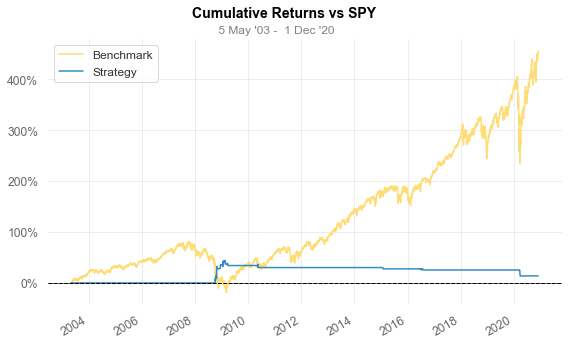

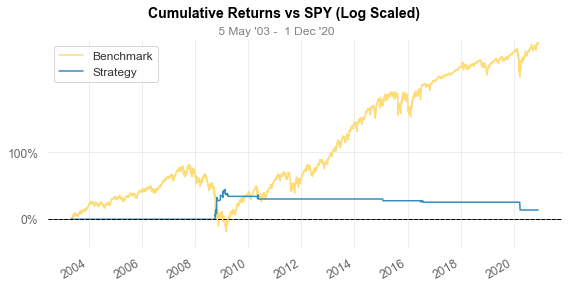

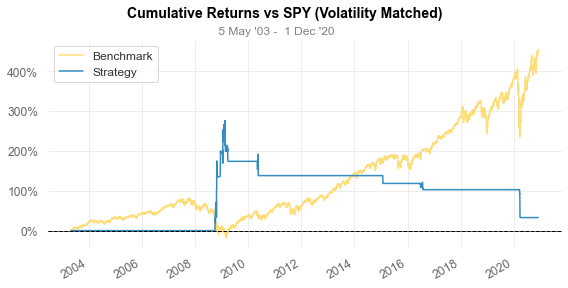

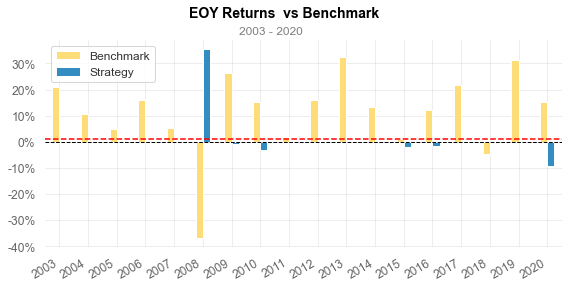

X:\Environments\Backtesting\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


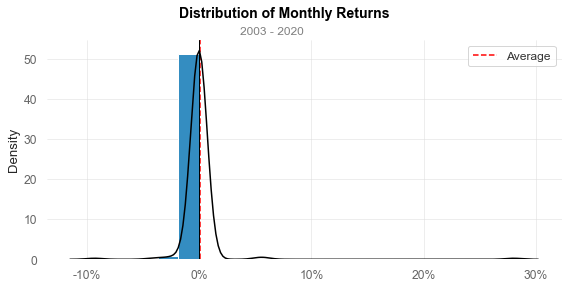

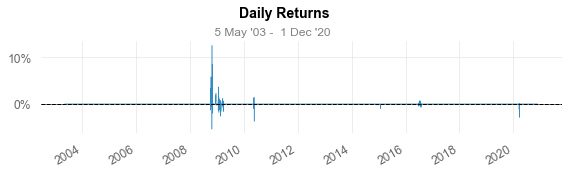

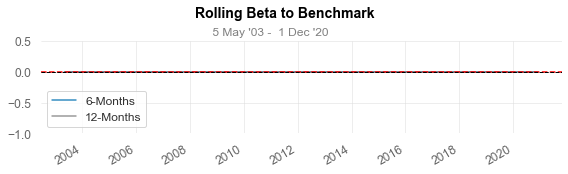

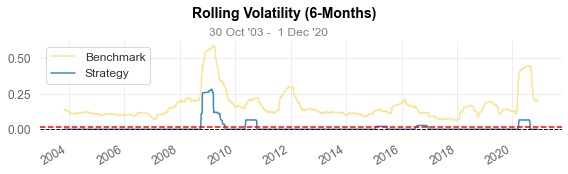

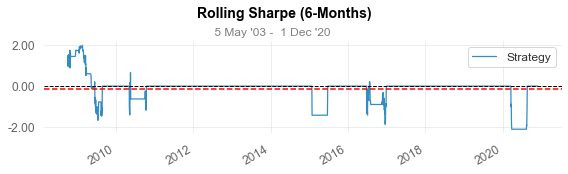

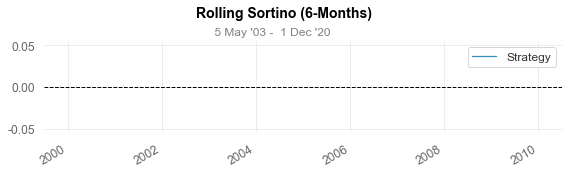

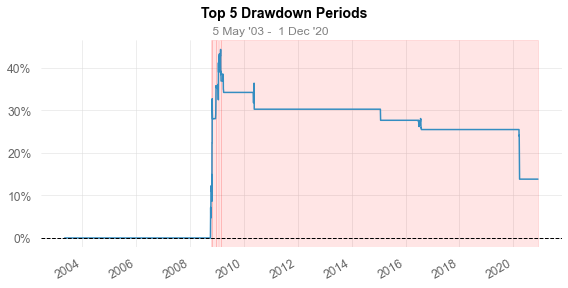

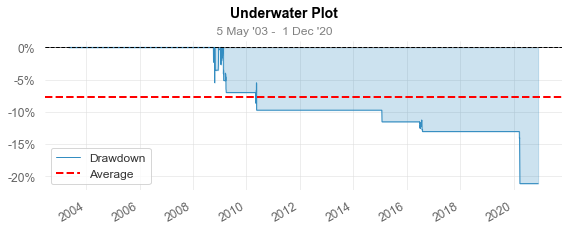

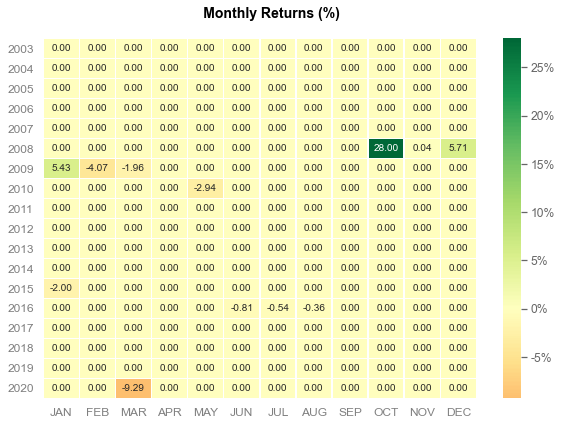

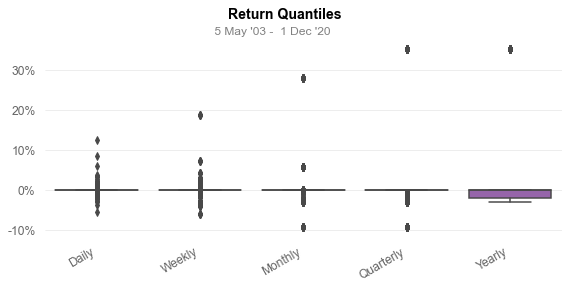

In [10]:
qs.reports.full(returns_qs,"SPY")

Start date,2015-11-02
End date,2019-12-11
Total months,49
,Backtest
Annual return,9.363%
Cumulative returns,44.426%
Annual volatility,7.465%
Sharpe ratio,1.24
Calmar ratio,1.21
Stability,0.89
Max drawdown,-7.754%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.75,2017-12-15,2018-05-07,2018-08-06,167
1,6.82,2016-08-26,2016-12-01,2017-02-01,114
2,6.16,2018-10-01,2019-08-23,2019-10-25,280
3,4.63,2017-05-12,2017-09-25,2017-11-03,126
4,2.50,2017-04-04,2017-04-13,2017-05-01,20


X:\Environments\Backtesting\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
X:\Environments\Backtesting\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
X:\Environments\Backtesting\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
X:\Environments\Backtesting\lib\site-packages\pandas\plo

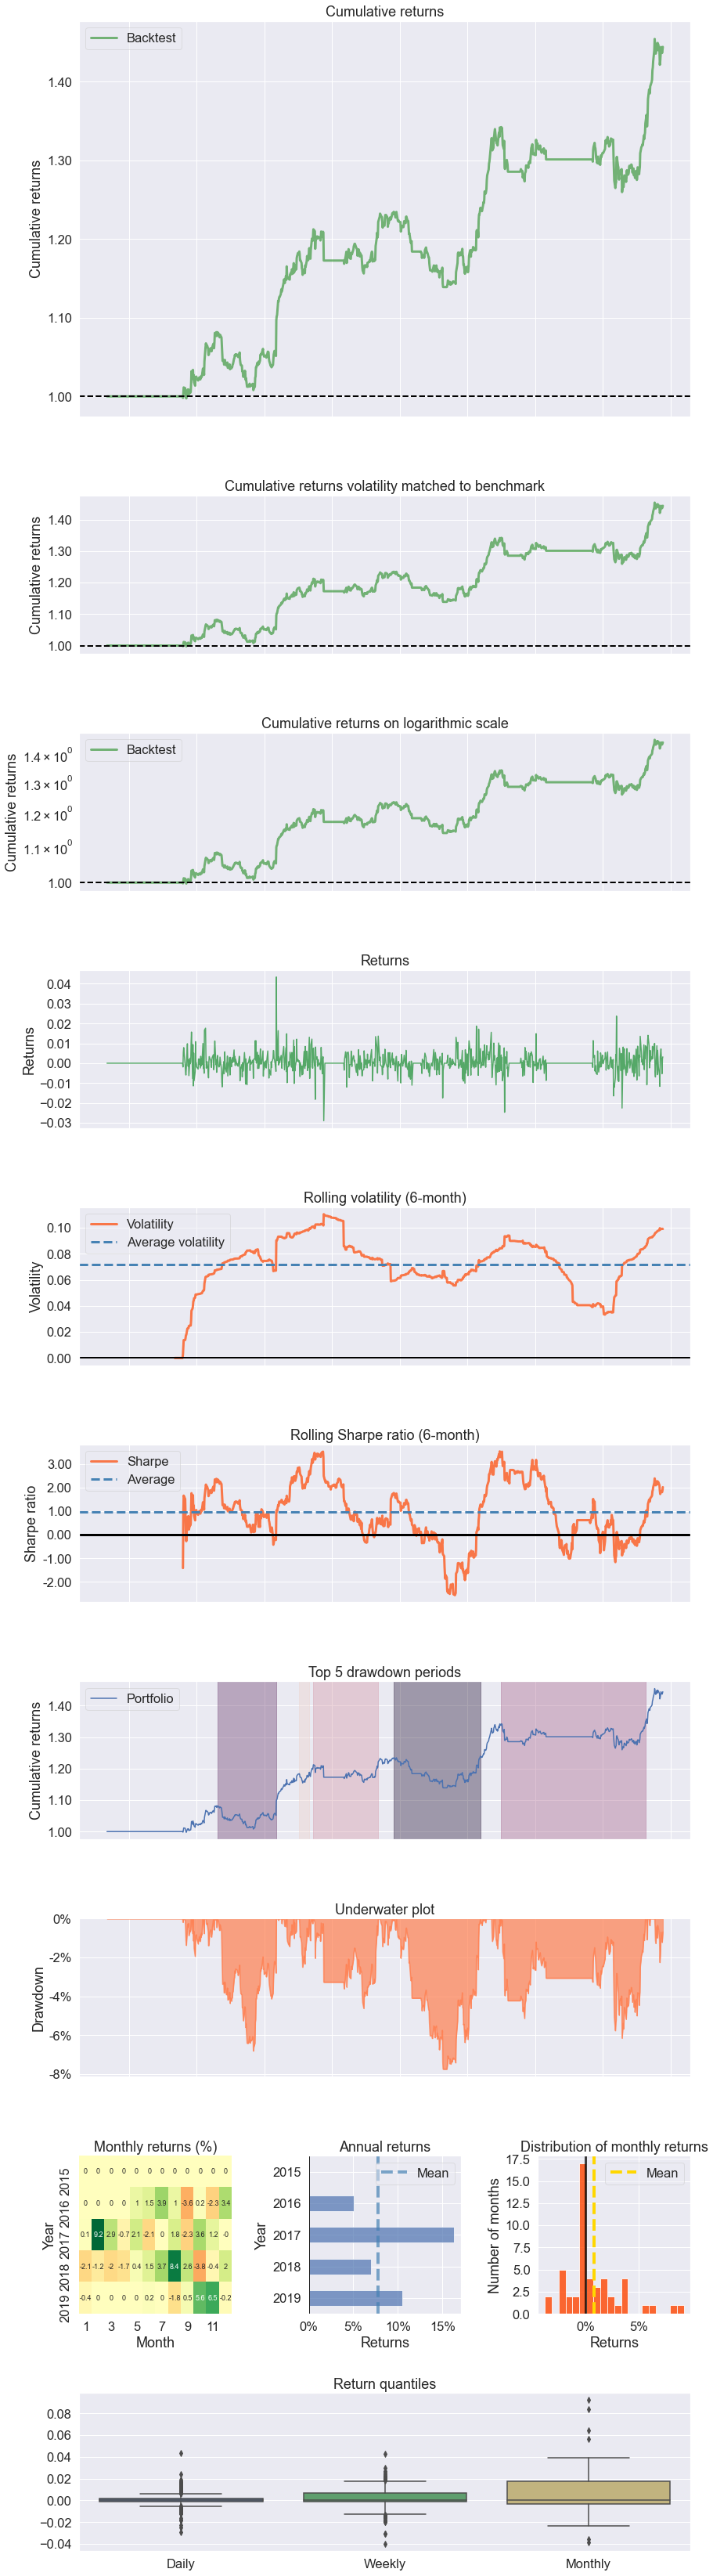

In [10]:
pf.create_full_tear_sheet(returns=returns,transactions=transactions)